# Libraries

In [1]:
## Initialzing and loading required libraries and subfunctions
import numpy as np
import matplotlib.pyplot as plt
import copy
import yasa
from mne.filter import resample
import pynapple as nap
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import requests
from io import BytesIO
import sails
import re
from scipy.stats import entropy


import scipy
from scipy import signal
from scipy.interpolate import griddata
from scipy.signal import correlate
from scipy.stats import pearsonr
from scipy.fft import fft
from scipy.spatial.distance import euclidean
from scipy.signal import spectrogram
from scipy.io import loadmat
import scipy.fft
import scipy.stats
import scipy.io as sio
from scipy.signal import hilbert
from scipy.signal import decimate
from scipy.ndimage import convolve1d

import pywt

import emd as emd
import emd.sift as sift
import emd.spectra as spectra

from neurodsp.sim import sim_combined
from neurodsp.plts import plot_time_series, plot_timefrequency
from neurodsp.utils import create_times
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from neurodsp.filt import filter_signal

# Load required libraries
import numpy as np
from scipy.io import loadmat
from scipy.signal import hilbert
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns
from neurodsp.filt import filter_signal, filter_signal_fir, design_fir_filter
import emd
import pandas as pd
from sklearn.preprocessing import Normalizer
from tqdm import tqdm
import plotly.express as px
import copy
# import umap.umap_ as umap
# import skdim
from scipy.spatial import cKDTree
import pickle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
from matplotlib.cm import ScalarMappable

## UTILS
from utils import *
from detect_pt import *

from scipy.io import loadmat
import numpy as np
from neurodsp.filt import filter_signal
import copy
import emd
from scipy.spatial import cKDTree
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from scipy.stats import zscore


sns.set(style='white', context='notebook')

# Code

In [2]:
path_to_hpc = r'D:\3__Donders\Sep2025\OS_basic_separated\6\CN\Post_trial1_2018-02-22_09-59-19\HPC_100_CH2.continuous.mat'
path_to_pfc = r'D:\3__Donders\Sep2025\OS_basic_separated\6\CN\Post_trial1_2018-02-22_09-59-19\PFC_100_CH33.continuous.mat'
path_to_states = r'D:\3__Donders\Sep2025\OS_basic_separated\6\CN\Post_trial1_2018-02-22_09-59-19\post_trial1_2018-02-22_09-59-19-states.mat'

In [40]:
path_to_hpc = r'D:\3__Donders\Sep2025\OS_basic_separated\11\HC\2018-11-02_10-56-09_Post_Trial1\HPC_100_CH32_0.continuous.mat'
path_to_pfc = r'D:\3__Donders\Sep2025\OS_basic_separated\11\HC\2018-11-02_10-56-09_Post_Trial1\PFC_100_CH45_0.continuous.mat'
path_to_states = r'D:\3__Donders\Sep2025\OS_basic_separated\11\HC\2018-11-02_10-56-09_Post_Trial1\2018-11-02_10-56-09_post_trial1-states.mat'

In [2]:
path_to_hpc = r'D:\3__Donders\Sep2025\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\HPC_100_CH32_0.continuous.mat'
path_to_pfc = r'D:\3__Donders\Sep2025\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\PFC_100_CH45_0.continuous.mat'
path_to_states = r'D:\3__Donders\Sep2025\mani-data-example\mani-data-example\2018-11-05_14-15-28_Post_Trial5\2018-11-05_14-15-28_post_trial5-states.mat'

In [3]:
config = emd.sift.SiftConfig.from_yaml_file(r'D:\3__Donders\Sep2025\mani-data-example\mani-data-example\emd_masksift_CA1_config_2500.yml')

In [4]:
lfpPFC, hypno1, fs = get_data(path_to_pfc, path_to_states, 'PFC')
print(fs)
lfpHPC, hypno2, fs = get_data(path_to_hpc, path_to_states, 'HPC')
print(fs)

There was 0 in the dataset
2500
There was 0 in the dataset
2500


In [5]:
print(len(lfpPFC))

27037838


In [6]:
np.unique(hypno2)

array([1, 3, 4, 5], dtype=uint8)

In [7]:
def extract_pt_intervals(lfpHPC, hypno, fs=2500):
    targetFs = 500
    n_down = fs / targetFs
    start, end = get_start_end(hypno=hypno, sleep_state_id=5)
    rem_interval = nap.IntervalSet(start=start, end=end)
    fs = int(n_down * targetFs)
    t = np.arange(0, len(lfpHPC) / fs, 1 / fs)
    lfp = nap.TsdFrame(t=t, d=lfpHPC, columns=['HPC'])

    # Detect phasic intervals
    lfpHPC_down = preprocess(lfpHPC, n_down)
    phREM = detect_phasic(lfpHPC_down, hypno, targetFs)

    # Create phasic REM IntervalSet
    start, end = [], []
    for rem_idx in phREM:
        for s, e in phREM[rem_idx]:
            start.append(s / targetFs)
            end.append(e / targetFs)
    phasic_interval = nap.IntervalSet(start, end)

    # Calculate tonic intervals
    tonic_interval = rem_interval.set_diff(phasic_interval)
    print(f'Number of detected Tonic intrevals:{len(tonic_interval)}')
    # Apply a 100 ms duration threshold to tonic intervals
    min_duration = 0.1  # 100 ms in seconds
    durations = tonic_interval['end'] - tonic_interval['start']
    valid_intervals = durations >= min_duration
    tonic_interval = nap.IntervalSet(tonic_interval['start'][valid_intervals], tonic_interval['end'][valid_intervals])
    print(f'Number of detected Tonic intrevals after threshold:{len(tonic_interval)}')
    return phasic_interval, tonic_interval, lfp

In [8]:
phasic_interval_hpc, tonic_interval_hpc, lfp_hpc = extract_pt_intervals(lfpHPC, hypno2)

Number of detected Tonic intrevals:53
Number of detected Tonic intrevals after threshold:53


In [9]:
print("Tonic Intervals:")
print(tonic_interval_hpc.shape)
print(tonic_interval_hpc)
print("----------------------------------------------------")
print("Phasic Intervals:")
print(phasic_interval_hpc.shape)
print(phasic_interval_hpc)

Tonic Intervals:
(53, 2)
index    start     end
0        682.0     752.0
1        1060.0    1129.822
2        1130.914  1145.022
3        1146.334  1146.712
4        1149.976  1170.0
5        1224.0    1257.0
6        1756.0    1851.8
...      ...       ...
46       7409.172  7421.0
47       7706.0    7722.588
48       7724.31   7744.004
49       7746.174  7747.372
50       7748.31   7828.0
51       9598.0    9610.0
52       9667.0    9777.0
shape: (53, 2), time unit: sec.
----------------------------------------------------
Phasic Intervals:
(34, 2)
index    start     end
0        1129.822  1130.914
1        1145.022  1146.334
2        1146.712  1149.976
3        1851.8    1853.12
4        1868.71   1869.62
5        1875.494  1876.492
6        1878.442  1881.172
...      ...       ...
27       6929.556  6930.926
28       6932.14   6935.354
29       7386.538  7389.058
30       7408.16   7409.172
31       7722.588  7724.31
32       7744.004  7746.174
33       7747.372  7748.31
shape: (3

In [ ]:
def extract_imfs_by_pt_intervals(lfp, fs, interval, config, return_imfs_freqs=False):

    all_imfs = []
    all_imf_freqs = []
    rem_lfp = []
    all_masked_freqs = []
    for ii in range(len(interval)):
        start_idx = int(interval.loc[ii, 'start'] * fs)
        end_idx = int(interval.loc[ii, 'end'] * fs)
        sig_part = lfp[start_idx:end_idx]
        sig = np.array(sig_part)
        # print(len(sig))

        rem_lfp.append(sig)

        try:
            imf, mask_freq = sift.mask_sift(sig, **config) 
            # imf, mask_freq = sift.mask_sift(sig, ret_mask_freq=True)
        except Exception as e:
            print(f"EMD Sift failed: {e}. Skipping this interval.")
            continue
        all_imfs.append(imf)
        all_masked_freqs.append(mask_freq)

        imf_frequencies = imf_freq(imf, fs)
        all_imf_freqs.append(imf_frequencies)

    if return_imfs_freqs:
        return all_imfs, all_imf_freqs, rem_lfp
    else:
        return all_imfs

In [ ]:
tonic_imfs_hpc, tonic_imfs_freqs_hpc, tonic_rem_lpf_hpc = extract_imfs_by_pt_intervals(lfp_hpc, fs, tonic_interval_hpc, config, return_imfs_freqs=True)

phasic_imfs_hpc, phasic_imfs_freqs_hpc, phasic_rem_lpf_hpc = extract_imfs_by_pt_intervals(lfp_hpc, fs, phasic_interval_hpc, config, return_imfs_freqs=True)

In [ ]:
print("Tonic intervals imfs:")
for i, imf_mat in enumerate(tonic_imfs_hpc):
    print(f"Interval {i}: {imf_mat.shape}")  # (n_samples_in_interval, n_imfs) 
print("-----------------------------------") 
print("Phasic intervals imfs:")
for i, imf_mat in enumerate(phasic_imfs_hpc):
    print(f"Interval {i}: {imf_mat.shape}") 
    

In [ ]:
freqs_intervalll = tonic_imfs_freqs_hpc[0]
print("Frequencies for tonic interval 0:")
for imf_idx, freqs in enumerate(freqs_intervalll):
    print(f"IMF {imf_idx+1}: freq = {freqs}")


In [ ]:
interval_idx = 0
imf_mat = tonic_imfs_hpc[interval_idx]   
n_samples, n_imfs = imf_mat.shape

# Time axis in seconds
start_sec = float(tonic_interval_hpc.loc[interval_idx, 'start'])
end_sec   = float(tonic_interval_hpc.loc[interval_idx, 'end'])
t = np.linspace(start_sec, end_sec, n_samples)

# Create a 3x3 subplot grid
fig, axes = plt.subplots(3, 3, figsize=(12, 6), sharex=True, sharey=False)
axes = axes.flatten()

for k in range(n_imfs):
    axes[k].plot(t, imf_mat[:, k], linewidth=1)
    axes[k].set_title(f"IMF {k+1}", fontsize=10)
    axes[k].tick_params(axis='both', which='major', labelsize=8)
    axes[k].grid(alpha=0.3)

# Add x and y labels to outer plots only
for ax in axes[6:]:  # bottom row x-labels
    ax.set_xlabel("Time [s]", fontsize=10)
for ax in axes[::3]:  # left column y-labels
    ax.set_ylabel("Amplitude [µV]", fontsize=10)

fig.suptitle(f"Tonic Interval {interval_idx} – IMFs", fontsize=25, y=1.02)
plt.tight_layout()
plt.show()


In [15]:
def get_cycle_data(imf5, fs):
    cycle_data = {"fs": None, 'theta_imf': None,
                       "IP": None, "IF": None, "IP": None, "cycles": None}


    # Get cycles using IP
    IP, IF, IA = emd.spectra.frequency_transform(imf5, fs, 'hilbert')
    C = emd.cycles.Cycles(IP)
    cycles = get_cycles_with_metrics(C, imf5, IA, IF)

    cycle_data['fs'] = fs
    cycle_data['theta_imf'] = imf5
    cycle_data['IP'] = IP
    cycle_data['IF'] = IF
    cycle_data['IA'] = IA
    cycle_data['cycles'] = cycles
    return cycle_data

In [16]:
def extract_cycle_info(imfs, imf_frequencies, fs):

  all_FPPs = []
  all_cycles_se =[]
  all_cycles_ctrl = []

  theta_range = [5, 12]
  # frequencies = np.arange(15, 141, 1)
  frequencies = np.arange(20, 180, 1)
  angles=np.linspace(-180,180,19)
  fs = 2500

  for idx, imf in enumerate(imfs):
    cycle_data = get_cycle_data(imf[:, 5], fs)

    amp_thresh = np.percentile(cycle_data['IA'], 25) # higher than 25th percentile of the data
    lo_freq_duration = fs/5  # restrict the analysis to 5-12 Hz
    hi_freq_duration = fs/12

    conditions = ['is_good==1',
                        f'duration_samples<{lo_freq_duration}',
                        f'duration_samples>{hi_freq_duration}',
                        f'max_amp>{amp_thresh}']

    all_cycles = get_cycles_with_conditions(cycle_data['cycles'], conditions)

    subset_cycles_df = all_cycles.get_metric_dataframe(subset=True)
    subset_indices = subset_cycles_df['index'].values

    ctrl = emd.cycles.get_control_points(imf[:, 5], cycle_data['cycles'], mode='augmented')
    cycle_ctrls = get_cycle_ctrl(ctrl, subset_indices)
    all_cycles_ctrl.append(cycle_ctrls)
    all_cycles_inds = get_cycle_inds(all_cycles, subset_indices)
    cycles_inds = arrange_cycle_inds(all_cycles_inds)

    all_cycles_se.append(all_cycles_inds)

    freqs = imf_frequencies[idx]
    sub_theta, theta, supra_theta = tg_split(freqs, theta_range)
    supra_theta_sig = np.sum(imf.T[supra_theta], axis=0)

    # # Corrected Wavelet Transform Computation
    raw_data=sails.wavelet.morlet(supra_theta_sig, freqs=frequencies, sample_rate=fs, ncycles=5,ret_mode='power', normalise=None)
    supraPlot = scipy.stats.zscore(raw_data, axis=1)
    FPP = bin_tf_to_fpp(cycles_inds, supraPlot, bin_count=19)
    all_FPPs.append(FPP)

  return all_cycles_ctrl, all_cycles_se, all_FPPs

In [17]:
print(len(phasic_imfs_freqs_hpc))

34


In [ ]:
# HPC Theta Cycles
all_phasic_cycles_ctrls_hpc, all_phasic_cycles_se_hpc, all_phasic_FPPs_hpc = extract_cycle_info(phasic_imfs_hpc, phasic_imfs_freqs_hpc, fs)
all_tonic_cycles_ctrls_hpc, all_tonic_cycles_se_hpc, all_tonic_FPPs_hpc = extract_cycle_info(tonic_imfs_hpc, tonic_imfs_freqs_hpc, fs)



In [146]:
print(all_phasic_FPPs_hpc[1].shape)

(10, 160, 19)


In [20]:
# (number of cycles, freq bands, phase)
print(all_tonic_FPPs_hpc[0].shape)
print(len(all_tonic_cycles_se_hpc[0]))

(419, 160, 19)
419


In [21]:
k = 0

# FPPs = all_tonic_FPPs_hpc
# CYCLE_INDS = all_tonic_cycles_se_hpc
# CYCLE_CTRL = all_tonic_cycles_ctrls_hpc
# IMFss = tonic_imfs_hpc
# REM_LFP = tonic_rem_lpf_hpc

FPPs = all_phasic_FPPs_hpc
CYCLE_INDS = all_phasic_cycles_se_hpc
CYCLE_CTRL = all_phasic_cycles_ctrls_hpc
IMFss = phasic_imfs_hpc
REM_LFP = phasic_rem_lpf_hpc


FPP = FPPs[k]
all_cycles_inds = CYCLE_INDS[k]
all_cycles_ctrl = CYCLE_CTRL[k]
imf = IMFss[k]
firstRemLFP = REM_LFP[k]

In [97]:
print(np.min(FPP), np.max(FPP))

-1.526777702167068 5.558118861916318


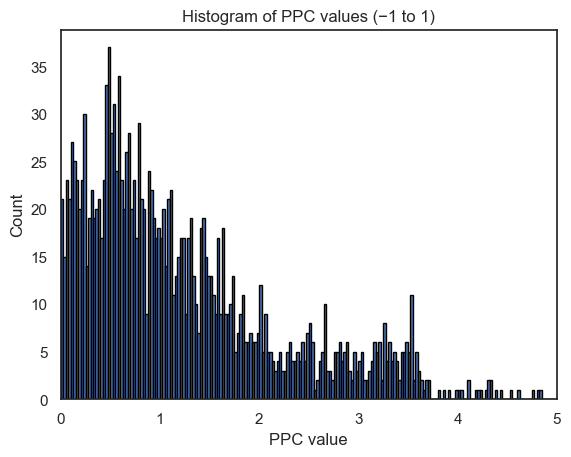

In [102]:
plt.figure()
plt.hist(
    FPP[5].ravel(),
    bins=200,
    range=(0, 5),
    edgecolor='black'
)
plt.xlabel("PPC value")
plt.ylabel("Count")
plt.title("Histogram of PPC values (−1 to 1)")
plt.xlim(0, 5)
plt.show()

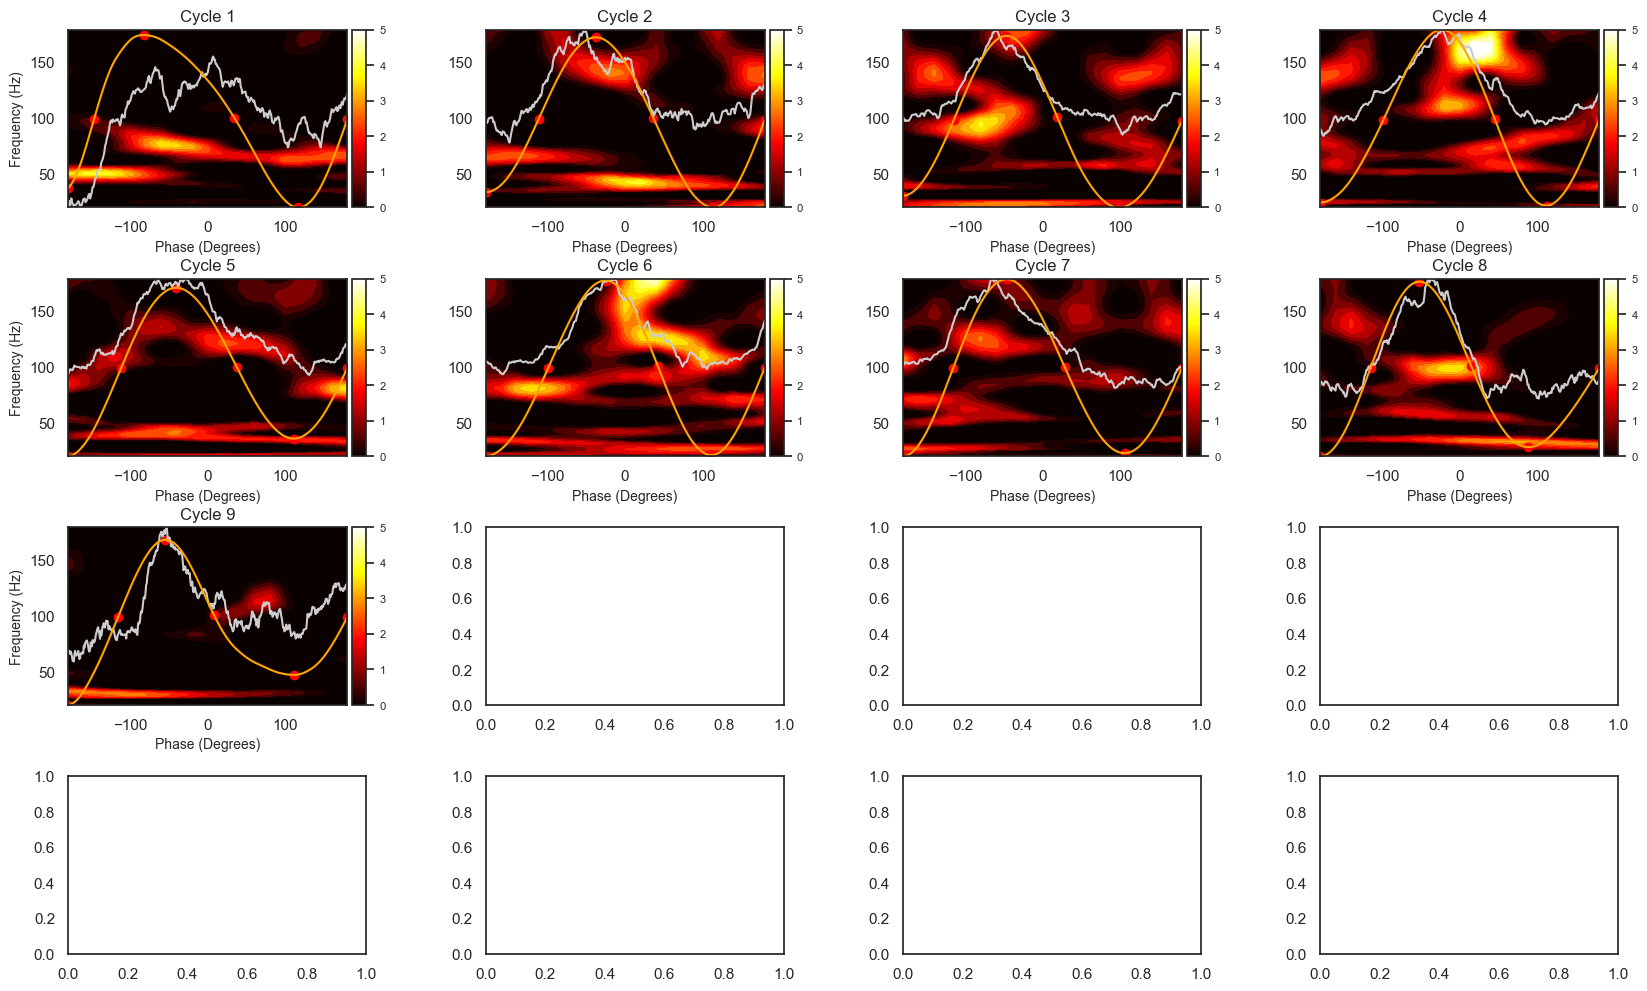

In [ ]:
frequencies = np.arange(20, 180, 1)
angles = np.linspace(-180, 180, 19)

n_rows, n_cols = 4, 4
max_plots = n_rows * n_cols

vmin = 0
vmax = 5

n_levels = 20
levels = np.linspace(np.min(FPP), np.max(FPP), n_levels)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 12))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

for ii in range(min(len(FPP), max_plots)):
    ax = axes[ii // n_cols, ii % n_cols]

    # Create contourf plot with specified levels and normalization
    im = ax.contourf(angles, frequencies, FPP[ii], levels=levels, cmap='hot', vmin=vmin, vmax=vmax)

    ax.set_xlabel(r'Phase (Degrees)', fontsize=10)
    if ii % n_cols == 0:
        ax.set_ylabel(r'Frequency (Hz)', fontsize=10)

    ax.set_title(f"Cycle {ii+1}", fontsize=12)
    
    xinds = np.arange(len(all_cycles_inds[ii]))
    raw_lfp = firstRemLFP[all_cycles_inds[ii]]
    theta_part = imf[all_cycles_inds[ii], 5]

    phase_scaled_xinds = np.linspace(angles.min(), angles.max(), len(xinds))
    lfp_scaled_y = (raw_lfp / np.max(np.abs(raw_lfp))) *  (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    theta_scaled_y = (theta_part / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()

    # Plot raw LFP and IMF-6 on the current axis
    ax.plot(phase_scaled_xinds, lfp_scaled_y, color=[0.8, 0.8, 0.8], label='Raw LFP')
    ax.plot(phase_scaled_xinds, theta_scaled_y, color='orange', label='IMF-6')

    # Plot control points
    ctrl_points_x = np.interp(all_cycles_ctrl[ii], np.arange(len(xinds)), phase_scaled_xinds)
    ctrl_points_y = (theta_part[all_cycles_ctrl[ii]] / np.max(np.abs(theta_part))) * (frequencies.max() - frequencies.min()) / 2 + frequencies.mean()
    ax.scatter(ctrl_points_x, ctrl_points_y, color='red', marker='o', label='Control Points')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = fig.colorbar(ScalarMappable(norm=im.norm, cmap=im.cmap), cax=cax, ticks=range(vmin, vmax+5, 5))
    im.set_clim(vmin, vmax)
    cbar.set_ticks(np.linspace(vmin, vmax, 6))
    cbar.ax.tick_params(labelsize=8)
plt.show()


In [23]:
# 1) Top-level containers (they're lists)
print("all_tonic_cycle_ctrls_hpc: len =", len(all_tonic_cycles_ctrls_hpc))
print("all_tonic_cycles_se_hpc : len =", len(all_tonic_cycles_se_hpc))
print("-----------------")
print("number of cycles in this interval: ", len(all_tonic_cycles_ctrls_hpc[0]))
print(all_tonic_cycles_ctrls_hpc[1])


all_tonic_cycle_ctrls_hpc: len = 53
all_tonic_cycles_se_hpc : len = 53
-----------------
number of cycles in this interval:  419
[array([  0,  78, 133, 188,   1, 310]), array([  0,  64, 122, 176, 234, 287]), array([  0,  56, 119, 190, 282, 369]), array([  0,  93, 174, 259,   6, 409]), array([  0,  78, 148, 240,  13, 312]), array([  0,  29, 119, 185, 268, 355]), array([  0,  82, 162, 237, 322, 445]), array([  0, 110, 190, 256, 331, 415]), array([  0,  83, 171, 258, 341, 467]), array([  0, 116, 237, 312, 395, 482]), array([  0,  86, 167, 237, 305, 387]), array([  0,  79, 174, 254, 326, 415]), array([  0, 112, 227, 305, 382, 460]), array([  0,  77, 170, 272, 359, 434]), array([  0,  74, 141, 207, 276, 352]), array([  0,  74, 165, 297, 397, 494]), array([  0,  93, 184, 261, 349, 467]), array([  0, 108, 202, 281, 372, 478]), array([  0,  98, 181, 262, 345, 445]), array([  0,  94, 181, 253, 327, 432]), array([  0,  97, 207, 319, 387, 445]), array([  0,  55, 130, 205, 304, 380]), array([  0, 

In [24]:
for i in range(len(all_tonic_cycles_se_hpc)):
    print(f"Interval {i+1}:")
    myInterval = all_tonic_cycles_se_hpc[i]
    for j in range(len(myInterval)):
        cyc_strt = myInterval[j][0]
        cyc_end = myInterval[j][-1]
        print(f"Cycle Start: {cyc_strt}, Cycle End: {cyc_end}")
    print("----------------------------------------")
    
print(len(myInterval))


Interval 1:
Cycle Start: 9, Cycle End: 425
Cycle Start: 359, Cycle End: 717
Cycle Start: 644, Cycle End: 938
Cycle Start: 854, Cycle End: 1301
Cycle Start: 1225, Cycle End: 1656
Cycle Start: 1601, Cycle End: 1886
Cycle Start: 1828, Cycle End: 2153
Cycle Start: 2087, Cycle End: 2513
Cycle Start: 2413, Cycle End: 2848
Cycle Start: 3134, Cycle End: 3573
Cycle Start: 3492, Cycle End: 3946
Cycle Start: 3852, Cycle End: 4269
Cycle Start: 4191, Cycle End: 4587
Cycle Start: 4504, Cycle End: 4876
Cycle Start: 4805, Cycle End: 5180
Cycle Start: 5106, Cycle End: 5526
Cycle Start: 5443, Cycle End: 5831
Cycle Start: 5752, Cycle End: 6187
Cycle Start: 6102, Cycle End: 6583
Cycle Start: 6902, Cycle End: 7317
Cycle Start: 7654, Cycle End: 8023
Cycle Start: 7944, Cycle End: 8346
Cycle Start: 8257, Cycle End: 8687
Cycle Start: 8631, Cycle End: 8927
Cycle Start: 8861, Cycle End: 9299
Cycle Start: 9205, Cycle End: 9652
Cycle Start: 9545, Cycle End: 10029
Cycle Start: 10336, Cycle End: 10807
Cycle Start: 1

In [25]:
control_points = all_tonic_cycles_ctrls_hpc[1]  
for i, cycle_ctrl in enumerate(control_points):
    print(f"Cycle {i}: Control points = {cycle_ctrl}")
    print(f"  Control points (indices): {cycle_ctrl}")

Cycle 0: Control points = [  0  78 133 188   1 310]
  Control points (indices): [  0  78 133 188   1 310]
Cycle 1: Control points = [  0  64 122 176 234 287]
  Control points (indices): [  0  64 122 176 234 287]
Cycle 2: Control points = [  0  56 119 190 282 369]
  Control points (indices): [  0  56 119 190 282 369]
Cycle 3: Control points = [  0  93 174 259   6 409]
  Control points (indices): [  0  93 174 259   6 409]
Cycle 4: Control points = [  0  78 148 240  13 312]
  Control points (indices): [  0  78 148 240  13 312]
Cycle 5: Control points = [  0  29 119 185 268 355]
  Control points (indices): [  0  29 119 185 268 355]
Cycle 6: Control points = [  0  82 162 237 322 445]
  Control points (indices): [  0  82 162 237 322 445]
Cycle 7: Control points = [  0 110 190 256 331 415]
  Control points (indices): [  0 110 190 256 331 415]
Cycle 8: Control points = [  0  83 171 258 341 467]
  Control points (indices): [  0  83 171 258 341 467]
Cycle 9: Control points = [  0 116 237 312 395

# PPC Calculation

In [26]:
# 1. Extracting tonic & phasic intervals from both HPC & PFC signals
fs = 2500
freq_range = np.arange(20, 182, 2) 
ph_intrvls_hpc = []
ph_intrvls_pfc = []
ton_intrvls_hpc = []
ton_intrvls_pfc = []
for i in range(len(all_tonic_cycles_se_hpc)):
    start_idx = int(tonic_interval_hpc[i, 0] * fs)
    end_idx   = int(tonic_interval_hpc[i, 1] * fs)
    ton_intrvls_hpc.append(lfpHPC[start_idx:end_idx])
    ton_intrvls_pfc.append(lfpPFC[start_idx:end_idx])
for i in range(len(all_phasic_cycles_se_hpc)):
    start_idx = int(phasic_interval_hpc[i, 0] * fs)
    end_idx   = int(phasic_interval_hpc[i, 1] * fs)
    ph_intrvls_hpc.append(lfpHPC[start_idx:end_idx])
    ph_intrvls_pfc.append(lfpPFC[start_idx:end_idx])

In [27]:
# 2. Wavelet Cross Spectrum (WCS) Calculation
ton_all_wcs = []
ph_all_wcs = []
for i in range (len(ton_intrvls_hpc)):
    cwt_lfp1, freqs_lfp1 = pywt.cwt(ton_intrvls_pfc[i], freq_range, 'cmor', sampling_period=1/fs)
    cwt_lfp2, freqs_lfp2 = pywt.cwt(ton_intrvls_hpc[i], freq_range, 'cmor', sampling_period=1/fs)
    cwt_lfp2_conj = np.conj(cwt_lfp2)
    wcs = cwt_lfp1 * cwt_lfp2_conj
    WCS_z = zscore(wcs, axis=1)
    ton_all_wcs.append(WCS_z)
    
for i in range (len(ph_intrvls_hpc)):
    cwt_lfp1, freqs_lfp1 = pywt.cwt(ph_intrvls_pfc[i], freq_range, 'cmor', sampling_period=1/fs)
    cwt_lfp2, freqs_lfp2 = pywt.cwt(ph_intrvls_hpc[i], freq_range, 'cmor', sampling_period=1/fs)
    cwt_lfp2_conj = np.conj(cwt_lfp2)
    wcs = cwt_lfp1 * cwt_lfp2_conj
    WCS_z = zscore(wcs, axis=1)
    ph_all_wcs.append(WCS_z)

c:\Users\Asusiran\AppData\Local\Programs\Python\Python313\Lib\site-packages\pywt\_cwt.py:113: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)
c:\Users\Asusiran\AppData\Local\Programs\Python\Python313\Lib\site-packages\pywt\_cwt.py:113: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)
c:\Users\Asusiran\AppData\Local\Programs\Python\Python313\Lib\site-packages\pywt\_cwt.py:113: FutureWarning: Wavel

In [37]:

print(ton_all_wcs[0].shape)
print(len(ton_all_wcs))
print(np.linspace(-180, 180, 19))

(81, 175000)
53
[-180. -160. -140. -120. -100.  -80.  -60.  -40.  -20.    0.   20.   40.
   60.   80.  100.  120.  140.  160.  180.]


In [38]:
# 3. Storing Theta cycles

ton_th_cyc_strt_end = []
ph_th_cyc_strt_end = []

for i in range(len(all_tonic_cycles_se_hpc)):
    row = []
    for j in range(len(all_tonic_cycles_se_hpc[i])):
        strt = all_tonic_cycles_se_hpc[i][j][0]
        end = all_tonic_cycles_se_hpc[i][j][-1]
        row.append([strt, end])
    ton_th_cyc_strt_end.append(row)

for i in range(len(all_phasic_cycles_se_hpc)):
    row = []
    for j in range(len(all_phasic_cycles_se_hpc[i])):
        strt = all_phasic_cycles_se_hpc[i][j][0]
        end = all_phasic_cycles_se_hpc[i][j][-1]
        row.append([strt, end])
    ph_th_cyc_strt_end.append(row)
    
    
print(np.array(ph_th_cyc_strt_end[0]))
        

[[   4  360]
 [ 298  624]
 [ 564  893]
 [ 819 1147]
 [1086 1409]
 [1348 1620]
 [1568 1856]
 [1797 2124]
 [2044 2492]]


In [39]:
# 4. time-freq -> freq-phase
ton_fpp_all = []
ph_fpp_all = []
for i in range(len(ton_th_cyc_strt_end)):
    cyc_array = np.array(ton_th_cyc_strt_end[i])
    ton_fpp_all.append(bin_tf_to_fpp(cyc_array, ton_all_wcs[i], 20))
for i in range(len(ph_th_cyc_strt_end)):
    cyc_array = np.array(ph_th_cyc_strt_end[i])
    ph_fpp_all.append(bin_tf_to_fpp(cyc_array, ph_all_wcs[i], 20))

In [40]:
print(ton_fpp_all[2].shape)

(85, 81, 20)


In [41]:
# for i in range(53):
#     NNN,_,_ = ph_fpp_all[i].shape
#     print(f'Phasic Intrvl {i+1}: {NNN} Cycles')
    


In [187]:
# 5. PPC formula
all_PPC_ton = []
all_PPC_ph = []
for fpp in ton_fpp_all:
    W = np.angle(fpp)  # Phase angles
    N, F, B = W.shape
    PPC = np.zeros((F, B), dtype=float)
    # Compute pairwise phase consistency
    for i in range(N):
        for j in range(N):
            PPC += np.cos(W[i] - W[j])  # Real part of the product of complex exponentials
    # Apply normalization term
    PPC = (PPC - N) / (N * (N - 1))
    all_PPC_ton.append(PPC)
    
for fpp in ph_fpp_all:
    W = np.angle(fpp)  # Phase angles
    N, F, B = W.shape
    PPC = np.zeros((F, B), dtype=float)
    # Compute pairwise phase consistency
    for i in range(N):
        for j in range(N):
            PPC += np.cos(W[i] - W[j])  # Real part of the product of complex exponentials
    # Apply normalization term
    PPC = (PPC - N) / (N * (N - 1))
    all_PPC_ph.append(PPC)

In [182]:
print(all_PPC_ton[3].shape)

(81, 20)


In [186]:
print(np.min(all_PPC_ton), np.max(all_PPC_ton))

-1.4999997781221517 0.15098904000366206


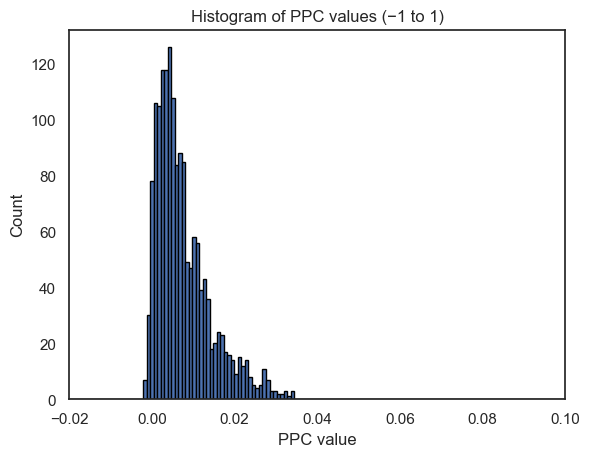

In [159]:
plt.figure()
plt.hist(
    all_PPC_ton[14].ravel(),
    bins=200,
    range=(-0.02, 0.15),
    edgecolor='black'
)
plt.xlabel("PPC value")
plt.ylabel("Count")
plt.title("Histogram of PPC values (−1 to 1)")
plt.xlim(-0.02, 
         0.1)
plt.show()

In [180]:
print("number of cycles in this interval: ", len(all_tonic_cycles_ctrls_hpc[21]))

number of cycles in this interval:  72


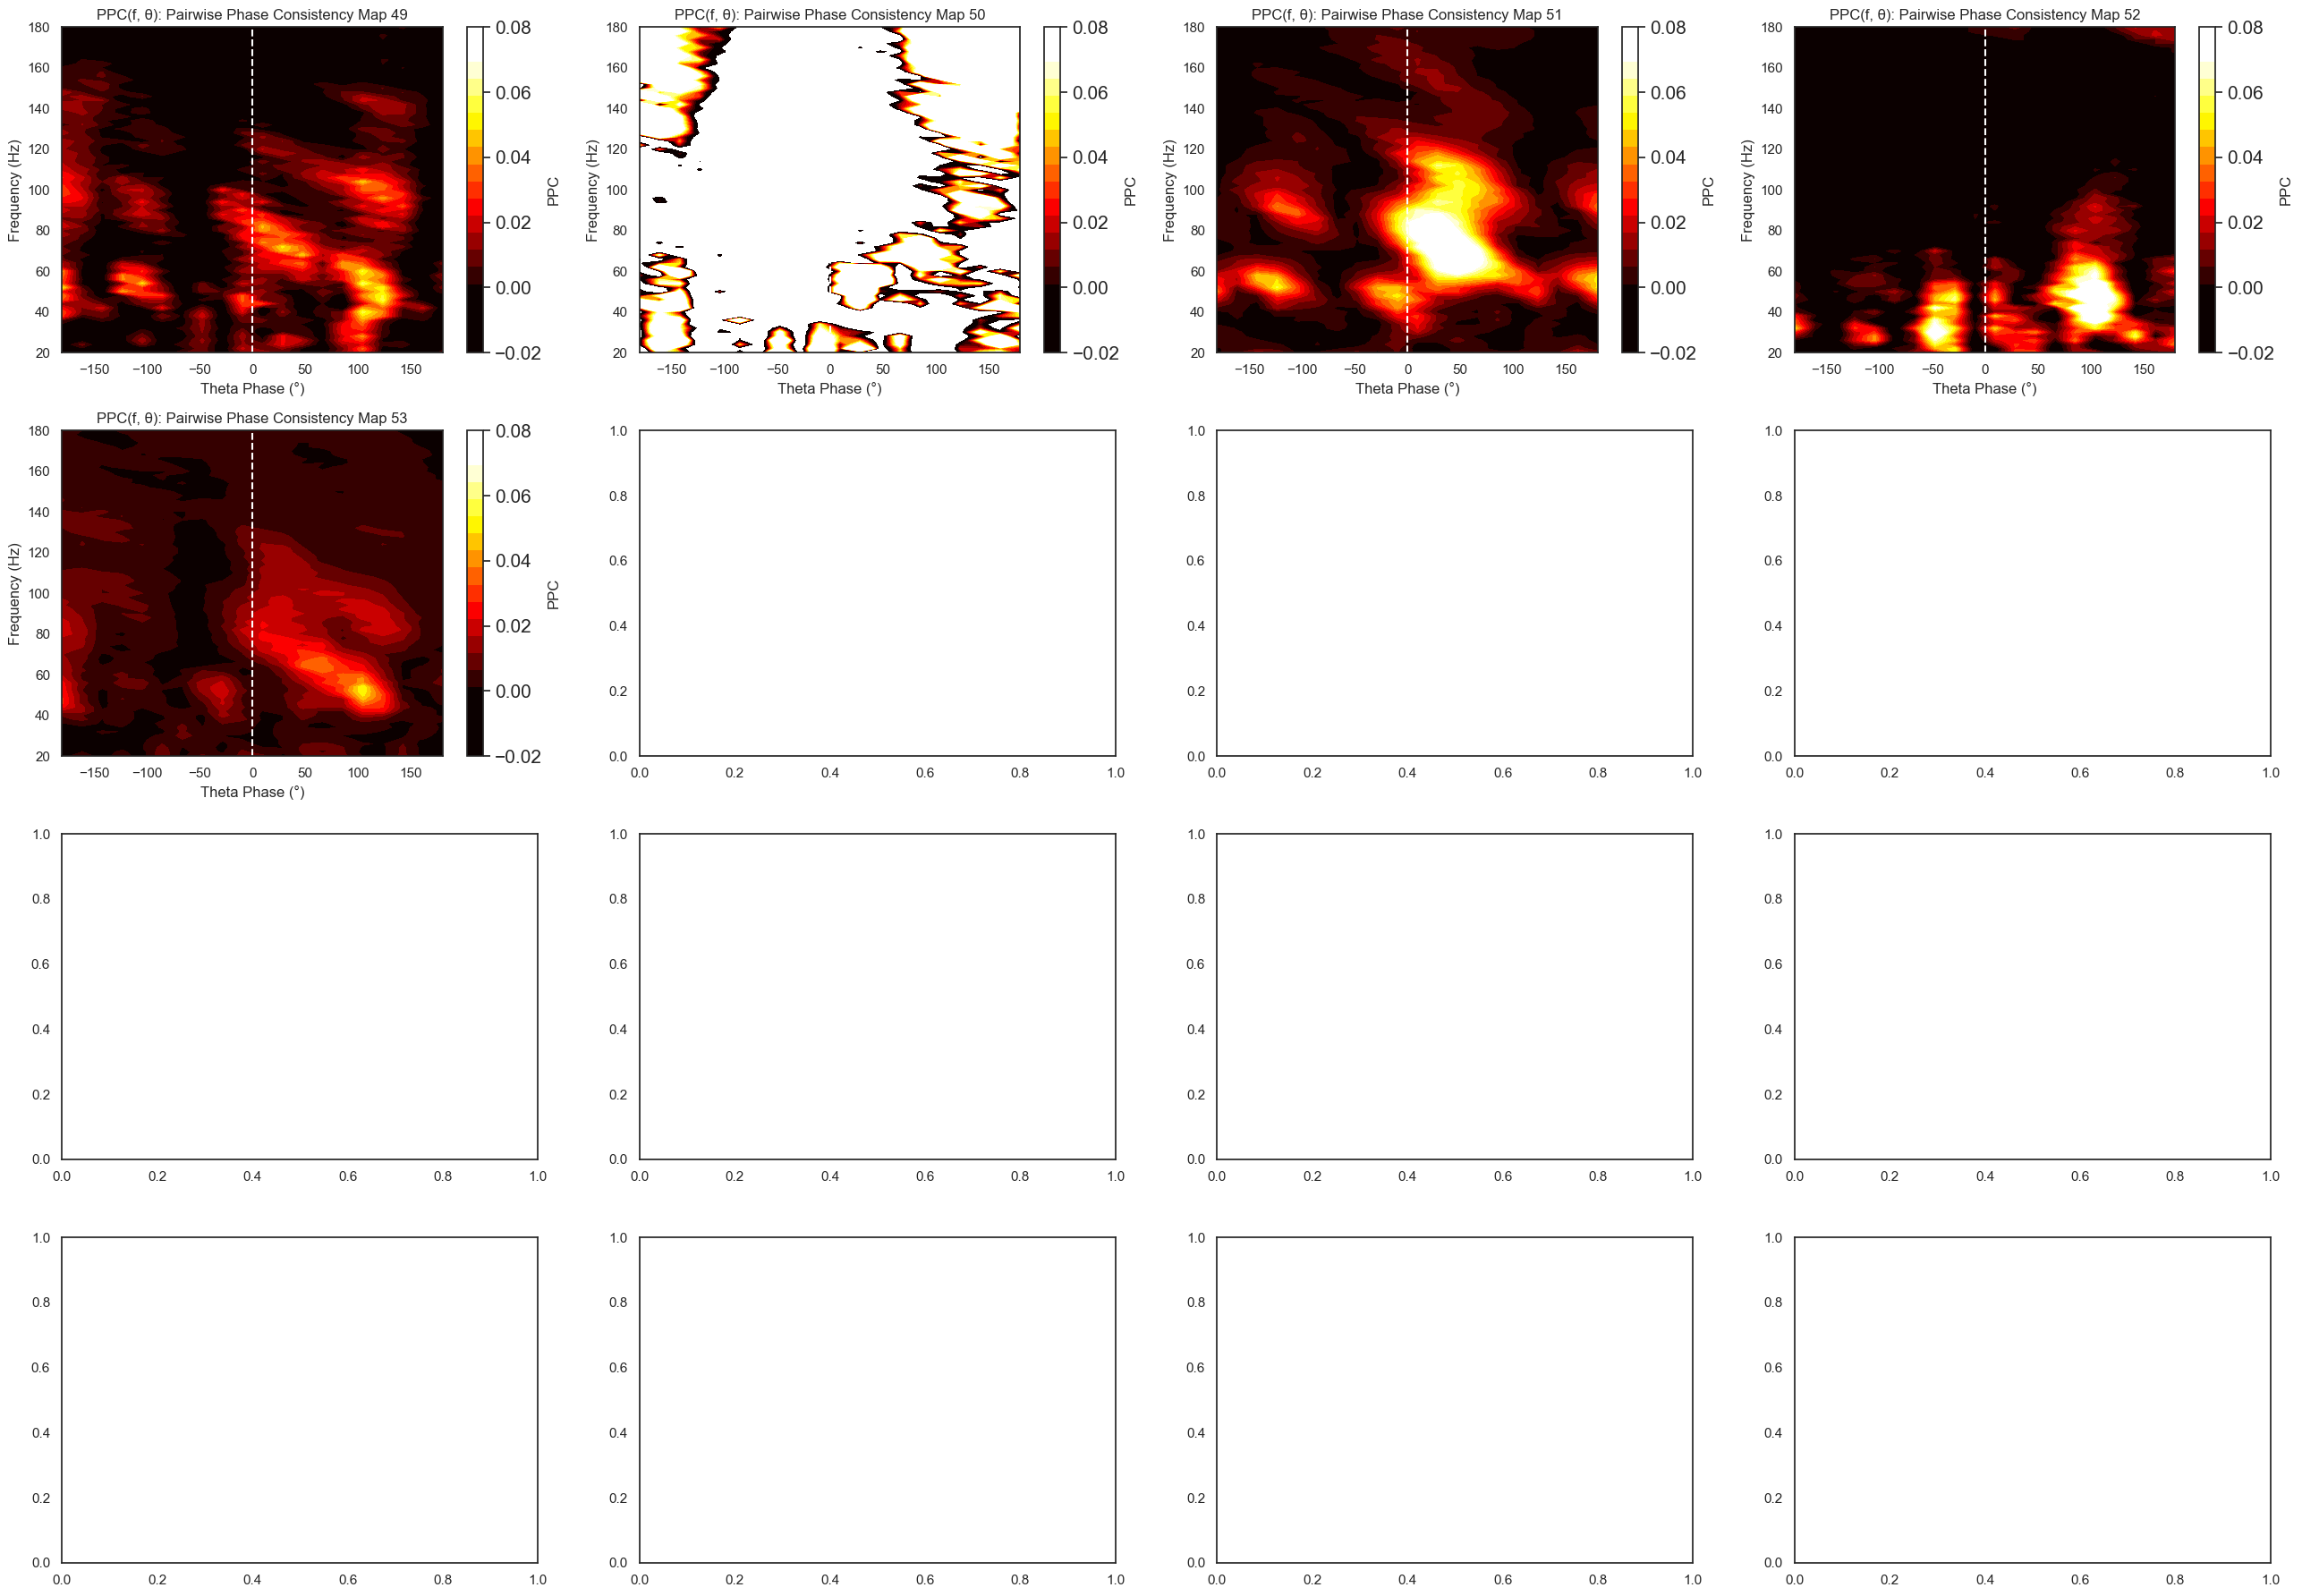

In [194]:
# 6. Visualize
freq_range = np.arange(20, 182, 2) 
angles = np.linspace(-180, 180, 20)   
fig, axes = plt.subplots(4, 4, figsize=(26, 18))  


# Flatten axes array to index it correctly
axes = axes.flatten()
levels1 = np.linspace(-0.02, 0.08, 20)
cbar_ticks = np.linspace(-0.02, 0.08, 6)
for i, PPC in enumerate(all_PPC_ton[48:54]):
    
    ax = axes[i]
    
    pcm = ax.contourf(angles, freq_range, PPC,levels=levels1, cmap='hot', vmin=-0.0009, vmax=0.07)

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label('PPC')
    cbar.set_ticks(cbar_ticks)
    cbar.ax.tick_params(labelsize=15)

    ax.set_xlabel('Theta Phase (°)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'PPC(f, θ): Pairwise Phase Consistency Map {i+49}')

    ax.axvline(0, color='white', linestyle='--', alpha=1)

plt.tight_layout()
plt.show()

In [121]:
print(levels1)

[-0.02       -0.01263158 -0.00526316  0.00210526  0.00947368  0.01684211
  0.02421053  0.03157895  0.03894737  0.04631579  0.05368421  0.06105263
  0.06842105  0.07578947  0.08315789  0.09052632  0.09789474  0.10526316
  0.11263158  0.12      ]


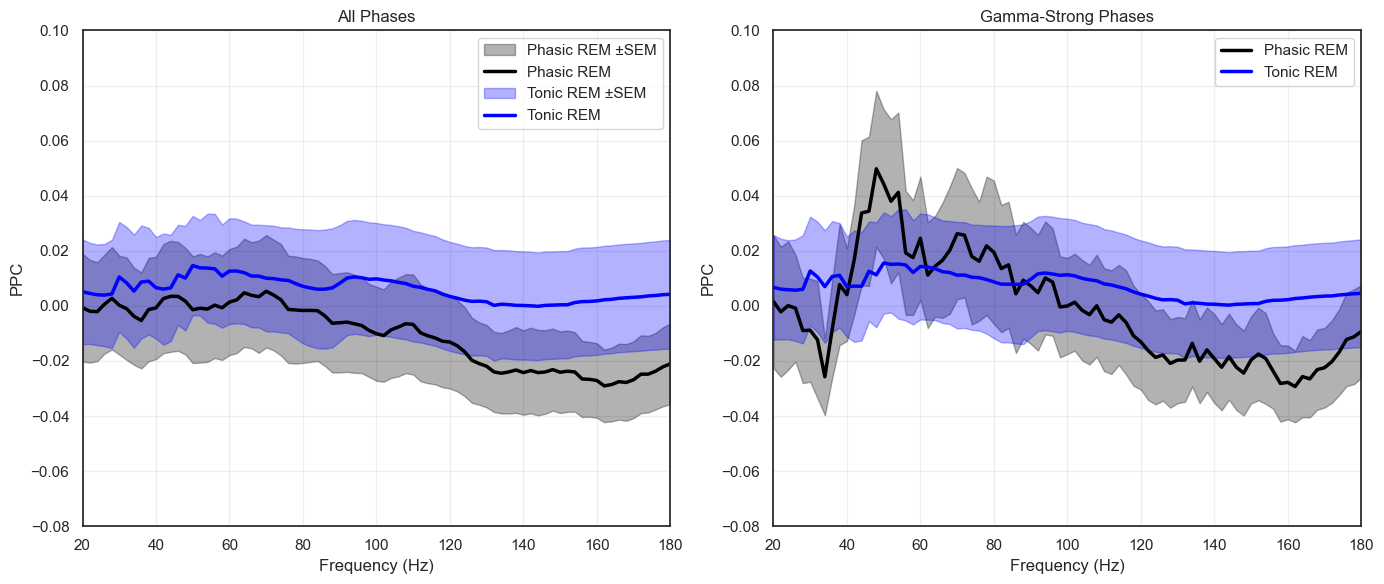

Tonic B: 19/20 phases | Phasic B: 2/20 phases


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
ymin = -0.08
ymax = 0.1

freq_range = np.arange(20, 182, 2)  # 81 frequencies

# === TONIC INTERVALS ===
ppc_tonic_3d = np.stack(all_PPC_ton, axis=0)  # [n_tonic, 81_freq, 20_phase]

# OPTION A: All phases
ppc_tonic_A = ppc_tonic_3d.mean(axis=(0, 2))  # mean
ppc_tonic_A_sem = ppc_tonic_3d.std(axis=(0, 2)) / np.sqrt(ppc_tonic_3d.shape[0])  # SEM

# OPTION B: Gamma-strong phases
peak_tonic = ppc_tonic_3d.max()
gamma_mask_tonic = ppc_tonic_3d > 0.9 * peak_tonic
strong_phases_tonic = np.unique(np.where(gamma_mask_tonic)[2])
phase_mask_tonic = np.isin(np.arange(20), strong_phases_tonic)
ppc_tonic_B = ppc_tonic_3d[:, :, phase_mask_tonic].mean(axis=(0, 2))
ppc_tonic_B_sem = ppc_tonic_3d[:, :, phase_mask_tonic].std(axis=(0, 2)) / np.sqrt(ppc_tonic_3d.shape[0])

# === PHASIC INTERVALS ===
ppc_phasic_3d = np.stack(all_PPC_ph, axis=0)

# OPTION A: All phases
ppc_phasic_A = ppc_phasic_3d.mean(axis=(0, 2))
ppc_phasic_A_sem = ppc_phasic_3d.std(axis=(0, 2)) / np.sqrt(ppc_phasic_3d.shape[0])

# OPTION B: Gamma-strong phases
peak_phasic = ppc_phasic_3d.max()
gamma_mask_phasic = ppc_phasic_3d > 0.9 * peak_phasic
strong_phases_phasic = np.unique(np.where(gamma_mask_phasic)[2])
phase_mask_phasic = np.isin(np.arange(20), strong_phases_phasic)
ppc_phasic_B = ppc_phasic_3d[:, :, phase_mask_phasic].mean(axis=(0, 2))
ppc_phasic_B_sem = ppc_phasic_3d[:, :, phase_mask_phasic].std(axis=(0, 2)) / np.sqrt(ppc_phasic_3d.shape[0])

# === PLOTTING ===
plt.figure(figsize=(14, 6))

# OPTION A
plt.subplot(1, 2, 1)
plt.fill_between(freq_range, ppc_phasic_A - ppc_phasic_A_sem, ppc_phasic_A + ppc_phasic_A_sem, 
                 alpha=0.3, color='black', label='Phasic REM ±SEM')
plt.plot(freq_range, ppc_phasic_A, label='Phasic REM', linewidth=2.5, color='black')

plt.fill_between(freq_range, ppc_tonic_A - ppc_tonic_A_sem, ppc_tonic_A + ppc_tonic_A_sem, 
                 alpha=0.3, color='blue', label='Tonic REM ±SEM')
plt.plot(freq_range, ppc_tonic_A, label='Tonic REM', linewidth=2.5, color='blue')

plt.xlabel('Frequency (Hz)')
plt.ylabel('PPC')
plt.title('All Phases')
plt.legend()
plt.xlim(20, 180)
plt.grid(True, alpha=0.3)
plt.ylim(ymin, ymax)

# OPTION B
plt.subplot(1, 2, 2)
plt.fill_between(freq_range, ppc_phasic_B - ppc_phasic_B_sem, ppc_phasic_B + ppc_phasic_B_sem, 
                 alpha=0.3, color='black')
plt.plot(freq_range, ppc_phasic_B, label='Phasic REM', linewidth=2.5, color='black')

plt.fill_between(freq_range, ppc_tonic_B - ppc_tonic_B_sem, ppc_tonic_B + ppc_tonic_B_sem, 
                 alpha=0.3, color='blue')
plt.plot(freq_range, ppc_tonic_B, label='Tonic REM', linewidth=2.5, color='blue')

plt.xlabel('Frequency (Hz)')
plt.ylabel('PPC')
plt.title('Gamma-Strong Phases')
plt.legend()
plt.xlim(20, 180)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.ylim(ymin, ymax)
plt.show()


print(f"Tonic B: {len(strong_phases_tonic)}/20 phases | Phasic B: {len(strong_phases_phasic)}/20 phases")
